In [1]:
import torch
import torch.linalg as tla
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

We want to simulate the PDE
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0 $$
on the domain $\Omega = [-1, 1]$, with initial and boundary conditions
$$\begin{align*}
u(x, 0) &= -\sin(\pi x) \\
u(-1, t) &= 0 \\
u(1, t) &= 0 \\
\end{align*}$$

For context, here is what the solution is supposed to look like: https://www.youtube.com/watch?v=bDNXNGpYj0c.

One way we can solve this PDE this is to *learn* the function $\hat{u}(x, t)$ that will approximate the solution, where
$$ \hat{u} : \mathbb{R}^2 \to \mathbb{R} $$
is a function parameterized by a feed-forward neural network.

In [77]:
# We will learn the function from t=0 to t=0.75
t0 = 0
t1 = 0.75

# Initial condition in time
def u0(x):
    return -torch.sin(torch.pi * x)

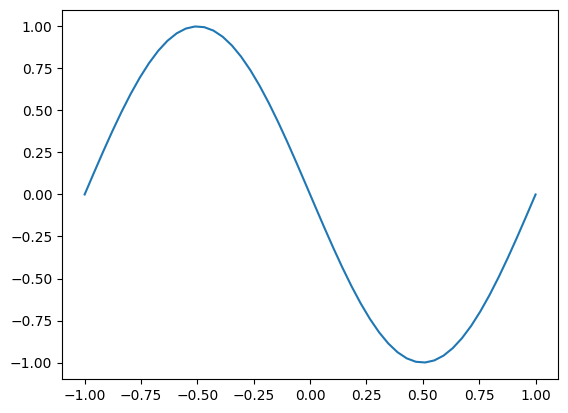

In [51]:
x = torch.linspace(-1, 1, 50)
plt.plot(x, u0(x), '-')

In [73]:
class FCN(torch.nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        N = 16
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(2, N), torch.nn.Tanh(),
            torch.nn.Linear(N, N), torch.nn.Tanh(),
            torch.nn.Linear(N, N), torch.nn.Tanh(),
            torch.nn.Linear(N, 1)
        )

    def forward(self, u, t):
        return self.fc_layers(torch.column_stack((u, t))).flatten()

def plot_solution(u_hat, t0, t1, grid_spacing=128, time_steps=50):
    fig, ax = plt.subplots()

    x = torch.linspace(-1, 1, grid_spacing)
    t = torch.linspace(t0, t1, time_steps)
    line, = ax.plot(x, u_hat(x, torch.ones_like(x) * t0).detach())

    def init():
        return line,

    def update(t_):
        line.set_data(x, u_hat(x, torch.ones_like(x) * t_).detach())
        return line,

    anim = FuncAnimation(fig, update, frames=t, init_func=init, blit=True, interval=40)
    plt.close(fig)
    return HTML(anim.to_html5_video())

In [74]:
u_hat = FCN()
plot_solution(u_hat, t0, t1)

Nothing interesting happens, but we haven't trained anything!  First, lets learn the initial condition by just optimizing $$\ell = \|\hat{u}(x, 0) - u(x, 0)\|$$ over some discrete samples $x$.

In [75]:
t = torch.zeros_like(x)
opt = torch.optim.Adam(u_hat.parameters(), lr=0.005)

for i in range(1_000):
    opt.zero_grad()
    ell = tla.norm(u_hat(x,t).flatten() - u0(x))
    ell.backward()
    opt.step()

    if i % 50 == 0:
        print(i, ell.item())

0 5.071537017822266
50 2.358429431915283
100 0.808200478553772
150 0.2721928358078003
200 0.05584967881441116
250 0.15816444158554077
300 0.37669631838798523
350 0.11069635301828384
400 0.3299265205860138
450 0.11283629387617111
500 0.2706666886806488
550 0.08329440653324127
600 0.07449229061603546
650 0.12887690961360931
700 0.10515912622213364
750 0.09599500894546509
800 0.09086192399263382
850 0.08699231594800949
900 0.08416088670492172
950 0.08162279427051544


In [76]:
plot_solution(u_hat, t0, t1)

That works, but notice how the boundary conditions are only respected at $t=0$.  Lets modify our loss function to penalize the boundary terms, giving us
$$\ell = \|\hat{u}(x, 0) - u(x, 0)\| + \|\hat{u}(-1, t)\| + \|\hat{u}(1, t)\|,$$
over now some discrete $x$, $t$.

In [56]:
# space, time for initial conditions
x_ic = torch.linspace(-1, 1, 50)
t_ic = torch.zeros_like(x)

# space, time for boundary conditions
t_bc = torch.linspace(t0, t1, 50)
x_l_bc = torch.ones_like(t_bc) * -1
x_r_bc = torch.ones_like(t_bc) * 1

opt = torch.optim.Adam(u_hat.parameters(), lr=0.001)

for i in range(1_000):
    opt.zero_grad()
    ell_ic = tla.norm(u_hat(x_ic, t_ic) - u0(x))
    ell_bc_l = tla.norm(u_hat(x_l_bc, t_bc))
    ell_bc_r = tla.norm(u_hat(x_r_bc, t_bc))
    ell = ell_ic + ell_bc_l + ell_bc_r
    ell.backward()
    opt.step()

    if i % 50 == 0:
        print(i, ell.item())

0 5.439061164855957
50 1.1425927877426147
100 0.3046734035015106
150 0.15000928938388824
200 0.12231627106666565
250 0.10864927619695663
300 0.10147608816623688
350 0.0939130038022995
400 0.08988747000694275
450 0.0863657146692276
500 0.08091212064027786
550 0.077827088534832
600 0.0749606192111969
650 0.07207244634628296
700 0.06998750567436218
750 0.0673997551202774
800 0.06550033390522003
850 0.06382596492767334
900 0.0624118372797966
950 0.06111769378185272


In [57]:
plot_solution(u_hat, t0, t1)

Now for the interesting part!  We still haven't satisfied the derivatives of the PDE! How do we do this without expensive derivative approximations?  Well, we can use PyTorch's autograd to compute the derivatives for us.  For our reference, here is the formulation of the PDE again:
$$ \frac{\partial u}{\partial t} +u \frac{\partial u}{\partial x} = 0 $$

Text(0, 0.5, 't')

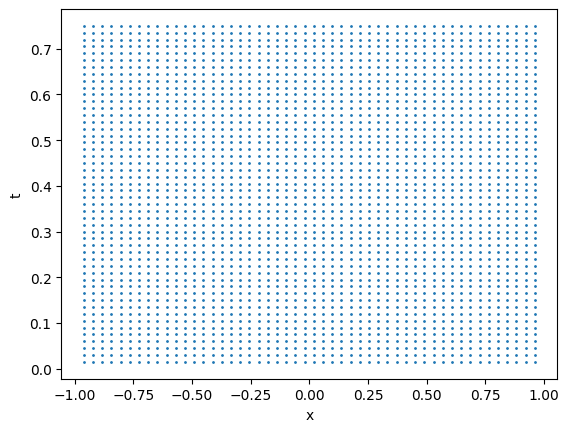

In [58]:
x_linear = torch.linspace(-1, 1, 52)[1:-1]
t_linear = torch.linspace(t0, t1, 51)[1:]

x_pde, t_pde = torch.meshgrid(x_linear, t_linear, indexing='ij')
x_pde = x_pde.flatten()
t_pde = t_pde.flatten()
x_pde.requires_grad = True
t_pde.requires_grad = True

# what does the above do? for each time step, it creates a spatial grid we can evaluate our function at.
plt.scatter(x_pde.detach(), t_pde.detach(), s=1.0)
plt.xlabel('x')
plt.ylabel('t')

In [59]:
u_eval = u_hat(x_pde, t_pde)

du_dx = torch.autograd.grad(u_eval, x_pde, 
                            grad_outputs=torch.ones_like(x_pde), # Shape of the output
                            create_graph=True, retain_graph=True)[0]

du_dt = torch.autograd.grad(u_eval, t_pde, 
                            grad_outputs=torch.ones_like(x_pde), # Shape of the output
                            create_graph=True, retain_graph=True)[0]

print(du_dx)
print(du_dt)

tensor([2.9899, 2.9884, 2.9867,  ..., 2.9511, 2.9479, 2.9446],
       grad_fn=<ReshapeAliasBackward0>)
tensor([-0.0412, -0.0404, -0.0395,  ..., -0.0029, -0.0030, -0.0030],
       grad_fn=<ReshapeAliasBackward0>)


How well do we currently satisfy the PDE portion?

In [60]:
torch.mean((du_dt + u_eval * du_dx)**2.)

tensor(1.2566, grad_fn=<MeanBackward0>)

Lets combine everything into one large loss function and train.

In [82]:
# space, time for initial conditions
x_ic = torch.linspace(-1, 1, 50)
t_ic = torch.zeros_like(x)

# space, time for boundary conditions
t_bc = torch.linspace(t0, t1, 50)
x_l_bc = torch.ones_like(t_bc) * -1
x_r_bc = torch.ones_like(t_bc) * 1

# space, time for pde residual
x_linear = torch.linspace(-1, 1, 52)[1:-1]
t_linear = torch.linspace(t0, t1, 20)[1:]

x_pde, t_pde = torch.meshgrid(x_linear, t_linear, indexing='ij')
x_pde = x_pde.flatten()
t_pde = t_pde.flatten()
x_pde.requires_grad = True
t_pde.requires_grad = True

opt = torch.optim.Adam(u_hat.parameters(), lr=1e-3)

for i in range(50_000):
    opt.zero_grad()
    ell_ic = tla.norm(u_hat(x_ic, t_ic) - u0(x))
    ell_bc_l = tla.norm(u_hat(x_l_bc, t_bc))
    ell_bc_r = tla.norm(u_hat(x_r_bc, t_bc))

    u_eval = u_hat(x_pde, t_pde)
    du_dx = torch.autograd.grad(u_eval, x_pde, 
                                grad_outputs=torch.ones_like(x_pde), # Shape of the output
                                create_graph=True, retain_graph=True)[0]
    
    du_dt = torch.autograd.grad(u_eval, t_pde, 
                                grad_outputs=torch.ones_like(x_pde), # Shape of the output
                                create_graph=True, retain_graph=True)[0]

    ell_pde_residual = torch.mean((du_dt + u_eval * du_dx)**2.)

    ell = ell_ic + ell_bc_l + ell_bc_r + ell_pde_residual
    ell.backward()
    opt.step()
    
    if i % 200 == 0:
        print(i, ell.item(), ell_ic.item(), (ell_bc_l + ell_bc_r).item(), ell_pde_residual.item())

0 0.18719522655010223 0.01941201090812683 0.04737277701497078 0.12041044235229492
200 0.1784828007221222 0.02938457578420639 0.030450791120529175 0.11864744126796722
400 0.18790601193904877 0.025925325229763985 0.04418005794286728 0.11780063062906265
600 0.16292721033096313 0.01954842545092106 0.025383612141013145 0.11799517273902893
800 0.20742610096931458 0.024759314954280853 0.06306305527687073 0.1196037232875824
1000 0.17368632555007935 0.023478591814637184 0.033399779349565506 0.11680794507265091
1200 0.1579456329345703 0.020520823076367378 0.019869012758135796 0.11755579710006714
1400 0.14893832802772522 0.01693969964981079 0.01458507589995861 0.11741355806589127
1600 0.19061556458473206 0.0272354893386364 0.04504930227994919 0.11833076924085617
1800 0.16061615943908691 0.021584205329418182 0.0221070796251297 0.11692488193511963
2000 0.14857859909534454 0.017018282786011696 0.014638524502515793 0.1169217899441719
2200 0.18687701225280762 0.025687286630272865 0.04399755224585533 0

In [85]:
plot_solution(u_hat, t0, t1)